# Курсовой проект для курса "Python для Data Science"

#### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Целевая переменная:
Price

#### Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

#### Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.


#### Описание датасета:
Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [498]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [499]:
TEST_DATASET_PATH = "test.csv"
TRAIN_DATASET_PATH = "train.csv"

In [500]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Уменьшаем объем данных

In [501]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [502]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

#### Разбиваем на тест и трейн

In [503]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop("Price", axis = 1), df["Price"], test_size=0.3, random_state=47)

In [504]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,7000.000000,7000.000000,7000.000000,7000.000000,5514.000000,7000.000000,7000.000000,7000.000000,7.000000e+03,7000.000000,7000.000000,7000.000000,7000.000000,3622.000000,7000.000000,7000.000000
mean,8355.944429,50.380286,1.890857,56.349125,36.334522,6.431143,8.465857,12.551143,4.849407e+03,0.118864,24.799000,5384.084286,8.007000,1164.085327,1.319286,4.228714
std,4859.364585,43.750859,0.850480,21.555962,20.853006,33.960041,5.200314,6.739928,2.396436e+05,0.118758,17.631259,4036.855151,23.562797,1037.780518,1.491194,4.780312
min,0.000000,0.000000,0.000000,1.988943,0.641822,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4179.750000,20.000000,1.000000,41.784348,22.726414,1.000000,4.000000,9.000000,1.973000e+03,0.019509,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8344.000000,35.000000,2.000000,52.413246,32.810188,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5288.000000,2.000000,990.000000,1.000000,3.000000
75%,12541.750000,75.000000,2.000000,65.981638,45.099518,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.000000,209.000000,19.000000,641.065186,638.163208,2014.000000,33.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


##### Для начала надо "причесать" имеющиеся не НаН значения, далее нужно избавиться от НаН значений.
- Id можно исключить из анализа, т.к. он не несет полезной информации, только индекс. Или использовать вместо индекса строк.
- District минимальный 0, врядли это верное значение, т.к. это скорее категориальное значение можно заменить модой
- Rooms 0 врядли верное значение, даже студия считается минимум 1 комнатой. Можно высчитать среднюю площадь на комнату из имеющихся данных и вставлять в 0 значения Lifesquare / среднее площадь и округлить до целого. Также стоит проверить максимальное значеие комнат. При 0.75 квантиле == 2, скорее всего это выброс.  
- Square минимальная и максимальная площадь подозрительны
- LifeSquare  также минимальная и максимальное значение подозрительны, вообще максимальная жилая площадь не может быть выше общей.
- KitchenSquare таже история с максимальным и минимальным. 
- Floor вроде все ок, разве что проверить максимальное значение..
- HouseFloor 0 этажей не может быть. 
- HouseYear посмотреть колонку отдельно
- Ecology_1	Social_1	Social_2	Social_3	Healthcare_1	Helthcare_2	Shops_1 не понятно, что за показатели, так что нужно посмотреть выбросы при помощи правила 3сигм, посмотреть через боксплот, и решить, что делать с выбросами. 

#### Id

In [505]:
X_train = X_train.set_index('Id')

#### DistrictId

In [506]:
X_train['DistrictId'].value_counts()

27     609
1      459
23     396
6      351
9      204
      ... 
181      1
117      1
196      1
112      1
207      1
Name: DistrictId, Length: 205, dtype: int64

В целом наблюдения похожи, так что скорее всего 0 это не выброс, а счет идет с 0 включительно. Т.к. этот признак номинальный, надо его привести к количественному. Как вариант, нормализовать по доли. Таким образом, мы номер района превратим в индекс популярности.

In [507]:
distict_dict = X_train["DistrictId"].value_counts(normalize=True).to_dict()

In [508]:
def districtid_to_stat(X):
    districtid = X["DistrictId"].to_list()
    for i, el in enumerate(districtid):
        if el in distict_dict:
            districtid[i] = distict_dict[el]
        else:
            districtid[i] = min(distict_dict.values())
    X["DistrictId"] = districtid
    return X

In [509]:
X_train = districtid_to_stat(X_train)

#### Rooms

In [510]:
X_train['Rooms'].value_counts()

2.0     2724
1.0     2590
3.0     1555
4.0      107
5.0       12
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Хоть по статистике и получается, что 4 и более комнат являются выбросами, но после просмотра данных по этим квартирам становится ясно, что 4 комнаты, это просто большие квартиры, а выбросы это  5 и более комнат.
По этому обработаем выбросы, заменив на ближайшее нормальное значение, и создадим доп признак для выделения изменения.  

In [511]:
X_train["Rooms_outlier"] = 0
X_train.loc[(X_train["Rooms"] >= 5), "Rooms_outlier"] = 1
X_train.loc[(X_train["Rooms"] >= 5), "Rooms"] = 4


#### KitchenSquare

In [512]:
X_train.loc[X_train["KitchenSquare"] > 150, "KitchenSquare"] = X_train["KitchenSquare"].median() # отсечем явно ошибочные значения

In [513]:
X_train["KitchenSquare_nan"] = 0
X_train.loc[X_train["KitchenSquare"].isnull(), "KitchenSquare_nan"] = 1
X_train.loc[X_train["KitchenSquare"].isnull(), "KitchenSquare"] = X_train["KitchenSquare"].median()

#### LifeSquare

Заполняя Нан значения средним или медианой по признаку, получается большой перекос, т.к. пропущенных значений слишком много.  Мы можем расчитать средний коэффициент отношения жилой площади к общей площади, и используя его спрогнозировать пропущенные значения.

In [514]:
X_train["LifeSquare_nan"] = 0
X_train.loc[X_train["LifeSquare"].isnull(), "LifeSquare_nan"] = 1

In [515]:
life_square_coef =  X_train["LifeSquare"].mean() / X_train["Square"].mean()
X_train.loc[X_train["LifeSquare"].isnull(), "LifeSquare"] = X_train.loc[X_train["LifeSquare"].isnull(), "Square"] * life_square_coef

#### Floor

Как правило первый и последний этажи стоят дешевле, можно это пометить.


In [516]:
bad_floor = (X_train["Floor"] == 1) | (X_train["Floor"] == X_train["HouseFloor"])
X_train["Bad_floor"] = 0
X_train.loc[bad_floor, "Bad_floor"] = 1

#### HouseFloor	

In [517]:
X_train.loc[X_train["HouseFloor"] == 0].head(5) # 0 этажей явно ошибка

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,KitchenSquare_nan,LifeSquare_nan,Bad_floor
Id,,,,,,,,,,,,,,,,,,,,,
770,0.008429,0.0,49.483501,31.907494,0.0,16,0.0,2015,0.118537,B,...,6207,1,1183.0,1,0,B,0,0,1,0
4579,0.003000,2.0,48.148067,31.046391,0.0,6,0.0,1977,0.236108,B,...,3893,27,NaN,3,10,B,0,0,1,0
5383,0.008714,3.0,98.994911,63.832981,0.0,3,0.0,1977,0.041125,B,...,9515,5,NaN,1,10,B,0,0,1,0
10414,0.026000,1.0,46.416927,29.930134,0.0,8,0.0,1977,0.072158,B,...,629,1,NaN,0,0,A,0,0,1,0
9194,0.087000,1.0,51.018288,22.370991,0.0,4,0.0,2016,0.017647,B,...,469,0,NaN,0,0,B,0,0,0,0


In [518]:
X_train["HouseFloor_outlier"] = 0
X_train.loc[X_train["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
X_train.loc[X_train["HouseFloor"] == 0, "HouseFloor"] = X_train.loc[X_train["HouseFloor"] == 0, "Floor"]

#### HouseYear

In [519]:
from datetime import datetime
x = datetime.now()
X_train.loc[X_train["HouseYear"] > x.year, "HouseYear"] = X_train["HouseYear"].median()
X_train["HouseYear"] = x.year - X_train["HouseYear"]


<AxesSubplot:>

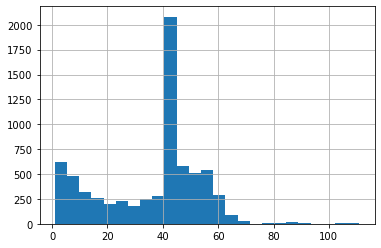

In [520]:
X_train["HouseYear"].hist(bins=25)

In [521]:
X_train['Ecology_2'] = (X_train['Ecology_2'] == 'A').astype(int)
X_train['Ecology_3'] = (X_train['Ecology_3'] == 'A').astype(int)
X_train['Shops_2'] = (X_train['Shops_2'] == 'A').astype(int)

#### Healthcare_1 

--- Начало Healthcare_1 ---

Спрогнозируем Нан значения через модель.

In [522]:
def x_test_prepare2(X_test_prepare, medians):
    
    
    
    kitchenSquare, houseyear = medians
    
    X_test_prepare = districtid_to_stat(X_test_prepare)
   
 
    X_test_prepare["Rooms_outlier"] = 0
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 5), "Rooms_outlier"] = 1
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 5), "Rooms"] = 4
    

    X_test_prepare.loc[X_test_prepare["KitchenSquare"] > 150, "KitchenSquare"] = kitchenSquare
    
    X_test_prepare["KitchenSquare_nan"] = 0
    X_test_prepare.loc[X_test_prepare["KitchenSquare"].isnull(), "KitchenSquare_nan"] = 1
    X_test_prepare.loc[X_test_prepare["KitchenSquare"].isnull(), "KitchenSquare"] = kitchenSquare
    
    
    
    X_test_prepare["LifeSquare_nan"] = 0
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare_nan"] = 1
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare"] = X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "Square"] * life_square_coef
    
    X_test_bad_floor = (X_test_prepare["Floor"] == 1) | (X_test_prepare["Floor"] == X_test_prepare["HouseFloor"])
    X_test_prepare["Bad_floor"] = 0
    X_test_prepare.loc[X_test_bad_floor, "Bad_floor"] = 1
    
       
    X_test_prepare["HouseFloor_outlier"] = 0
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor"] = X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "Floor"]
    
    x = datetime.now()
    X_test_prepare.loc[X_test_prepare["HouseYear"] > x.year, "HouseYear"] = houseyear
    X_test_prepare["HouseYear"] = x.year - X_test_prepare["HouseYear"]
    
    
  
    X_test_prepare['Ecology_2'] = (X_test_prepare['Ecology_2'] == 'A').astype(int)
    X_test_prepare['Ecology_3'] = (X_test_prepare['Ecology_3'] == 'A').astype(int)
    X_test_prepare['Shops_2'] = (X_test_prepare['Shops_2'] == 'A').astype(int) 
   
    return X_test_prepare

In [523]:
X_train_H = X_train.loc[X_train['Healthcare_1'].notnull()]
y_2 = X_train_H["Healthcare_1"]
X_train_H = X_train_H.drop(['Healthcare_1'], axis = 1)

In [524]:
gb_model2 = GradientBoostingRegressor(criterion='mse', min_samples_leaf=10, random_state=42, max_depth = 5, max_features=6, n_estimators=200)
gb_model2.fit(X_train_H, y_2)

GradientBoostingRegressor(criterion='mse', max_depth=5, max_features=6,
                          min_samples_leaf=10, n_estimators=200,
                          random_state=42)

In [525]:
X_nan_healthcare_1 = (X_train.loc[X_train['Healthcare_1'].isnull()]).drop('Healthcare_1', axis = 1)
y_pred_healthcare_1 = gb_model2.predict(X_nan_healthcare_1)
X_train.loc[X_train['Healthcare_1'].isnull(), 'Healthcare_1'] = y_pred_healthcare_1

--- Конец Healthcare_1 ---

### Попробуем Кластеризовать данные
Глядя на гистограммы площади можно предположить, что можно выявить 3-4 кластера.

In [526]:
scaler = MinMaxScaler()

In [527]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [528]:
from sklearn.cluster import KMeans

In [529]:
X_train.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Rooms_outlier', 'KitchenSquare_nan',
       'LifeSquare_nan', 'Bad_floor', 'HouseFloor_outlier'],
      dtype='object')

In [567]:
list_km = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare'] # Попробуем разделить квартиры на кластеры по их основным хар-кам

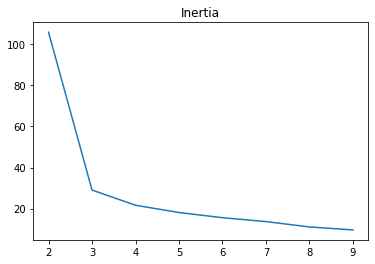

In [568]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(X_train_scaled[list_km])
    
    temp_inertia = temp_model.inertia_
    
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)

plt.title('Inertia')

plt.show()

Попробуем разабить на 3 кластера.

In [569]:
model_km = KMeans(n_clusters=3, random_state=42, max_iter=100)

In [570]:
train_labels = model_km.fit_predict(X_train_scaled[list_km])

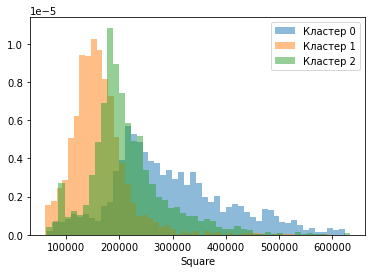

In [571]:
plt.hist(y_train.loc[train_labels == 0], bins=50, density=True, alpha=0.5)
plt.hist(y_train.loc[train_labels == 1], bins=50, density=True, alpha=0.5)
plt.hist(y_train.loc[train_labels == 2], bins=50, density=True, alpha=0.5)


plt.legend(['Кластер 0', 'Кластер 1', 'Кластер 2'])
plt.xlabel('Square')

plt.show()

In [ ]:
gb_model = GradientBoostingRegressor(criterion='mse', min_samples_leaf=10, random_state=42, max_depth = 5, max_features=6, n_estimators=200)

In [ ]:
gb_model.fit(X_train.loc[train_labels == 0], y_train[train_labels == 0])

y_valid_pred_0 = gb_model.predict(X_train.loc[train_labels_test == 0])

r2(y_valid[train_labels_test == 0], y_valid_pred_0)

In [ ]:
gb_model.fit(X_train.loc[train_labels == 0], y_train[train_labels == 0])

y_valid_pred_0 = gb_model.predict(X_valid.loc[train_labels_test == 0])

r2(y_valid[train_labels_test == 0], y_valid_pred_0)

In [ ]:
gb_model.fit(X_train.loc[train_labels == 0], y_train[train_labels == 0])

y_valid_pred_0 = gb_model.predict(X_valid.loc[train_labels_test == 0])

r2(y_valid[train_labels_test == 0], y_valid_pred_0)

### Подготавливаем тестовый сет

In [535]:

medians = X_train["KitchenSquare"].median(), X_train["HouseYear"].median()

In [536]:
def x_test_prepare(X_test_prepare, medians, list_km):

    
    kitchenSquare, houseyear = medians
    
    X_test_prepare = X_test_prepare.set_index('Id')
    X_test_prepare = districtid_to_stat(X_test_prepare)
   
    X_test_prepare["Rooms_outlier"] = 0
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 5), "Rooms_outlier"] = 1
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 5), "Rooms"] = 4
    
    X_test_prepare.loc[X_test_prepare["KitchenSquare"] > 150, "KitchenSquare"] = kitchenSquare
    
    X_test_prepare["KitchenSquare_nan"] = 0
    X_test_prepare.loc[X_test_prepare["KitchenSquare"].isnull(), "KitchenSquare_nan"] = 1
    X_test_prepare.loc[X_test_prepare["KitchenSquare"].isnull(), "KitchenSquare"] = kitchenSquare
    
    
    X_test_prepare["LifeSquare_nan"] = 0
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare_nan"] = 1
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare"] = X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "Square"] * life_square_coef
    
    X_test_bad_floor = (X_test_prepare["Floor"] == 1) | (X_test_prepare["Floor"] == X_test_prepare["HouseFloor"])
    X_test_prepare["Bad_floor"] = 0
    X_test_prepare.loc[X_test_bad_floor, "Bad_floor"] = 1
    

    X_test_prepare["HouseFloor_outlier"] = 0
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor"] = X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "Floor"]
    
    x = datetime.now()
    X_test_prepare.loc[X_test_prepare["HouseYear"] > x.year, "HouseYear"] = houseyear
    X_test_prepare["HouseYear"] = x.year - X_test_prepare["HouseYear"]
    
    
    X_test_prepare['Ecology_2'] = (X_test_prepare['Ecology_2'] == 'A').astype(int)
    X_test_prepare['Ecology_3'] = (X_test_prepare['Ecology_3'] == 'A').astype(int)
    X_test_prepare['Shops_2'] = (X_test_prepare['Shops_2'] == 'A').astype(int) 
    
    X_nan_healthcare_2 = (X_test_prepare.loc[X_test_prepare['Healthcare_1'].isnull()]).drop('Healthcare_1', axis = 1)
    y_pred_healthcare_2 = gb_model2.predict(X_nan_healthcare_2)
    X_test_prepare.loc[X_test_prepare['Healthcare_1'].isnull(), 'Healthcare_1'] = y_pred_healthcare_2
    
    
    X_test_prepare_scaled = pd.DataFrame(scaler.fit_transform(X_test_prepare), columns=X_test_prepare.columns)
    train_labels_test = model_km.predict(X_test_prepare_scaled[list_km])
   
    return X_test_prepare, train_labels_test

In [537]:
X_valid, train_labels_test = x_test_prepare(X_valid, medians, list_km)

### Обучаем модель

Подбор гиперпараметров

#### Финальная модель

In [539]:
gb_model = GradientBoostingRegressor(criterion='mse', min_samples_leaf=10, random_state=42, max_depth = 5, max_features=6, n_estimators=200)

In [558]:
X_valid.loc[train_labels_test == 1]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,KitchenSquare_nan,LifeSquare_nan,Bad_floor,HouseFloor_outlier
Id,,,,,,,,,,,,,,,,,,,,,
3614,0.003429,1.0,65.857742,29.912815,17.0,7,22.0,11,0.111627,0,...,8,1970.000000,2,3,0,0,0,0,0,0
15515,0.010286,1.0,33.144245,19.227783,5.0,2,4.0,61,0.133215,0,...,3,1406.000000,3,4,1,0,0,0,0,0
3710,0.011286,1.0,42.311771,27.283085,1.0,17,1.0,44,0.195781,0,...,6,1622.187134,3,2,0,0,0,1,0,0
8046,0.009571,2.0,48.965889,31.110107,5.0,6,5.0,56,0.225825,1,...,7,1548.000000,3,2,0,0,0,0,0,0
3661,0.050143,1.0,39.362293,38.530064,9.0,14,17.0,5,0.243205,0,...,0,540.000000,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11369,0.050143,2.0,62.497536,40.299084,1.0,7,17.0,5,0.243205,0,...,0,540.000000,0,0,0,0,0,1,0,0
7906,0.005429,1.0,39.998470,21.143106,6.0,8,9.0,46,0.007720,0,...,2,2446.364014,0,4,0,0,0,0,0,0
7263,0.016429,1.0,44.141472,28.462894,0.0,11,17.0,44,0.437885,0,...,3,1084.000000,0,5,0,0,0,1,0,0


In [549]:
gb_model.fit(X_train.loc[train_labels == 0], y_train[train_labels == 0])

y_valid_pred_0 = gb_model.predict(X_valid.loc[train_labels_test == 0])

r2(y_valid[train_labels_test == 0], y_valid_pred_0)

0.57464010038929

In [541]:
gb_model.fit(X_train.loc[train_labels == 1], y_train[train_labels == 1])

y_valid_pred_1 = gb_model.predict(X_valid.loc[train_labels_test == 1])

r2(y_valid[train_labels_test == 1], y_valid_pred_1)

0.6156734206902263

In [542]:
gb_model.fit(X_train.loc[train_labels == 2], y_train[train_labels == 2])

y_valid_pred_2 = gb_model.predict(X_valid.loc[train_labels_test == 0])

r2(y_valid[train_labels_test == 2], y_valid_pred_2)

ValueError: Found input variables with inconsistent numbers of samples: [0, 729]

In [ ]:
def evaluate_preds(true_values, pred_values, save=False):
        
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()

### Итоговый результат

In [ ]:
evaluate_preds(y_valid, y_pred)


In [ ]:
0.76

Выбросы подогнали под границы.

In [ ]:
f_i = gb_model.feature_importances_

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()